In [1]:
import pandas as pd
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [2]:
def parser(x):
	return pd.to_datetime(x)

case_death_data = pd.read_csv(Path('./Resources/us_states_daily.csv'), header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
case_death_data.head()

,state,fips,cases,deaths,case_day,death_day
date,,,,,,
2020-03-13,Alabama,1,6,0,6,0
2020-03-14,Alabama,1,12,0,6,0
2020-03-15,Alabama,1,23,0,11,0
2020-03-16,Alabama,1,29,0,6,0
2020-03-17,Alabama,1,39,0,10,0


In [3]:
# Get California data only
ca_case_df = case_death_data.loc[case_death_data['state'] == 'California']
ca_case_df = ca_case_df.drop(columns=["state", "fips", "cases", "deaths"])
ca_case_df.sample(40)

,case_day,death_day
date,,
2020-06-07,2850,27
2020-02-21,1,0
2020-04-09,1148,42
2020-04-21,1982,93
2020-04-06,1208,37
2020-02-24,2,0
2020-03-23,389,4
2020-02-09,0,0
2020-03-26,877,15


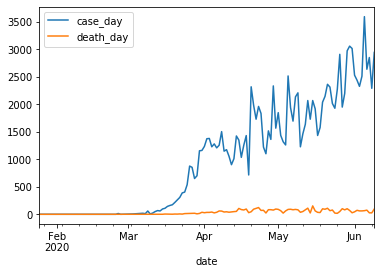

In [4]:
ca_case_df.plot()
plt.show()

Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms.

## Feature Engineering for Time Series

### 1. Date Time Features

In [5]:
# dataframe['month'] = [series.index[i].month for i in range(len(series))]
# dataframe['day'] = [series.index[i].day for i in range(len(series))]
# add day of the week as feature
# add month of the year as a feature
# Doing this enables us to capture trends, seasonal or cyclical pattern from our dataset.

### 2.  Lag Features

In [6]:
# add lag_one using shift()
ca_case_df["case_day_lag_one"] = ca_case_df['case_day'].shift(1)
ca_case_df.head(20)

,case_day,death_day,case_day_lag_one
date,,,
2020-01-25,1,0,NaN
2020-01-26,1,0,1.0
2020-01-27,0,0,1.0
2020-01-28,0,0,0.0
2020-01-29,0,0,0.0
2020-01-30,0,0,0.0
2020-01-31,1,0,0.0
2020-02-01,0,0,1.0
2020-02-02,3,0,0.0


In [7]:
# add lag_one using shift()
ca_case_df["case_day_lag_two"] = ca_case_df['case_day'].shift(2)
# first value in lag one is nan droping that row
ca_case_df.head(20)

,case_day,death_day,case_day_lag_one,case_day_lag_two
date,,,,
2020-01-25,1,0,NaN,NaN
2020-01-26,1,0,1.0,NaN
2020-01-27,0,0,1.0,1.0
2020-01-28,0,0,0.0,1.0
2020-01-29,0,0,0.0,0.0
2020-01-30,0,0,0.0,0.0
2020-01-31,1,0,0.0,0.0
2020-02-01,0,0,1.0,0.0
2020-02-02,3,0,0.0,1.0


In [8]:
# drop the narows
ca_case_df.dropna(inplace=True)

In [9]:
## Add more lags and test the model performace

In [10]:
## since the cases distribution is skewed by the comperativly low cases at the begginig of the pandemic
## i choose to drop the first 40 cases

### 3. Window Features

#### - Rolling window

In [11]:
# calculating the rolling mean
# mean_case_day_case_day_lag_one
ca_case_df["mean_rolling_window_lag_one"] = ca_case_df["case_day_lag_one"].rolling(window=40).mean()
ca_case_df.dropna(inplace=True)
ca_case_df.head(20)

,case_day,death_day,case_day_lag_one,case_day_lag_two,mean_rolling_window_lag_one
date,,,,,
2020-03-06,14,0,12.0,10.0,1.650
2020-03-07,19,0,14.0,12.0,1.975
2020-03-08,12,0,19.0,14.0,2.450
2020-03-09,60,1,12.0,19.0,2.750
2020-03-10,7,1,60.0,12.0,4.250
2020-03-11,23,1,7.0,60.0,4.425
2020-03-12,50,0,23.0,7.0,4.975
2020-03-13,68,1,50.0,23.0,6.225
2020-03-14,61,0,68.0,50.0,7.850


#### - Expanding window

In [12]:
# Expanding Window Statistics
ca_case_df["diff_case_day_one"] = ca_case_df["case_day"] - ca_case_df["case_day_lag_one"]
ca_case_df.dropna(inplace=True)
ca_case_df.head(20)

,case_day,death_day,case_day_lag_one,case_day_lag_two,mean_rolling_window_lag_one,diff_case_day_one
date,,,,,,
2020-03-06,14,0,12.0,10.0,1.650,2.0
2020-03-07,19,0,14.0,12.0,1.975,5.0
2020-03-08,12,0,19.0,14.0,2.450,-7.0
2020-03-09,60,1,12.0,19.0,2.750,48.0
2020-03-10,7,1,60.0,12.0,4.250,-53.0
2020-03-11,23,1,7.0,60.0,4.425,16.0
2020-03-12,50,0,23.0,7.0,4.975,27.0
2020-03-13,68,1,50.0,23.0,6.225,18.0
2020-03-14,61,0,68.0,50.0,7.850,-7.0


In [13]:
# use the logs to stabalize the variance


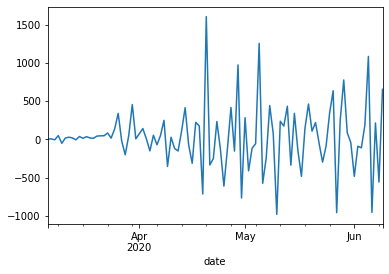

In [14]:
# make the case_day stationary differenciating 
ca_case_df["diff_case_day_one"].plot()
plt.show()

In [15]:
# Scale/Normalize your data
# Just remember to scale them back once you’ve done your prediction.

In [16]:
# add testing data
testing_data = pd.read_csv(Path('./Resources/US_COVID_TESTS.csv'), header=0, parse_dates=[2], index_col=2, squeeze=True, date_parser=parser)
testing_data.head()


,Country/Region,Province/State,positive,positiveIncrease,negative,negativeIncrease,pending,pendingIncrease,death,deathIncrease,...,hospitalizedCumulative,hospitalizedCumulativeIncrease,inIcuCurrently,inIcuCurrentlyIncrease,inIcuCumulative,inIcuCumulativeIncrease,onVentilatorCurrently,onVentilatorCurrentlyIncrease,onVentilatorCumulative,onVentilatorCumulativeIncrease
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-07,United States,Alabama,0.0,0,NaN,0,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08,United States,Alabama,0.0,0,NaN,0,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-09,United States,Alabama,0.0,0,NaN,0,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-10,United States,Alabama,0.0,0,0.0,0,0.0,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-11,United States,Alabama,0.0,0,10.0,10,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
all_testing_ca = testing_data[testing_data["Province/State"] == "California"]
testing_ca = all_testing_ca.drop(columns=[
    'Country/Region',
     'Province/State',
     'pending',
     'pendingIncrease',
     'positive',
     'negative',
     'total',
     'death',
     'deathIncrease',
     'hospitalized',
     'hospitalizedIncrease',
     'ISO3166-1',
     'ISO3166-2',
     'Last_Update_Date',
     'Last_Reported_Flag',
     'hospitalizedCurrently',
     'hospitalizedCurrentlyIncrease',
     'hospitalizedCumulative',
     'hospitalizedCumulativeIncrease',
     'inIcuCurrently',
     'inIcuCurrentlyIncrease',
     'inIcuCumulative',
     'inIcuCumulativeIncrease',
     'onVentilatorCurrently',
     'onVentilatorCurrentlyIncrease',
     'onVentilatorCumulative',
     'onVentilatorCumulativeIncrease'
])

In [18]:
testing_ca

,positiveIncrease,negativeIncrease,totalTestResultsIncrease
Date,,,
2020-03-04,0,0,0
2020-03-05,0,0,0
2020-03-06,7,0,7
2020-03-07,9,0,9
2020-03-08,19,0,19
...,...,...,...
2020-06-01,2423,65312,67735
2020-06-02,2304,56704,59008
2020-06-03,2377,57326,59703


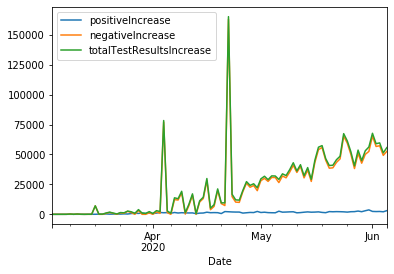

In [19]:
testing_ca.plot()
plt.show()

In [20]:
# add mobility data
# Global_Mobility_Report.csv
mobility_raw = pd.read_excel('./Resources/Global_Mobility_Report.xlsx', index_col=0) 

In [21]:
state_mobility = mobility_raw[mobility_raw["county"].isnull()]

In [22]:
# transform the date to datetime
import datetime as dt
state_mobility['datetime'] = pd.to_datetime(state_mobility['date'])

/usr/local/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
# set the date as index
state_mobility = state_mobility.set_index(['datetime'])

In [24]:
# remove the country, date columns
state_mobility = state_mobility.drop(columns=["county", "date"])

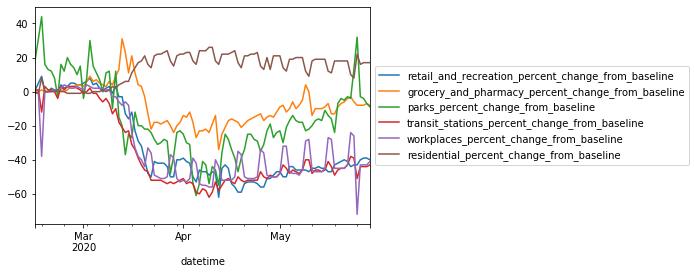

In [25]:
# plot the data
state_mobility.plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [27]:
# join all table in one 
# maybe join the data on ca_case_df
# ca_data = testing_ca.merge(state_mobility, left_index=True, right_index=True).merge(ca_case_df, left_index=True, right_index=True)
ca_data = ca_case_df.merge(state_mobility, left_index=True, right_index=True)

In [28]:
ca_data

,case_day,death_day,case_day_lag_one,case_day_lag_two,mean_rolling_window_lag_one,diff_case_day_one,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
2020-03-06,14,0,12.0,10.0,1.650,2.0,2.0,5.0,7.0,-4.0,2.0,0.0
2020-03-07,19,0,14.0,12.0,1.975,5.0,0.0,4.0,0.0,-6.0,2.0,1.0
2020-03-08,12,0,19.0,14.0,2.450,-7.0,2.0,3.0,11.0,-4.0,1.0,0.0
2020-03-09,60,1,12.0,19.0,2.750,48.0,3.0,6.0,12.0,-7.0,1.0,1.0
2020-03-10,7,1,60.0,12.0,4.250,-53.0,-1.0,4.0,-10.0,-13.0,-3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-25,2274,18,1928.0,2014.0,1724.625,346.0,-43.0,-8.0,32.0,-51.0,-72.0,22.0
2020-05-26,2908,51,2274.0,1928.0,1747.750,634.0,-40.0,-8.0,-3.0,-44.0,-43.0,16.0
2020-05-27,1949,102,2908.0,2274.0,1794.575,-959.0,-39.0,-8.0,-4.0,-44.0,-43.0,17.0
2020-05-28,2197,81,1949.0,2908.0,1811.900,248.0,-39.0,-7.0,-7.0,-44.0,-43.0,17.0


In [29]:
# import for Granger's Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
def test_causality(data):
    print(sm.tsa.stattools.grangercausalitytests(data, maxlag=20, verbose=True))

In [30]:
data = ca_data[["case_day", "retail_and_recreation_percent_change_from_baseline"]]
test_causality(data)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0056  , p=0.0487  , df_denom=81, df_num=1
ssr based chi2 test:   chi2=4.1540  , p=0.0415  , df=1
likelihood ratio test: chi2=4.0545  , p=0.0441  , df=1
parameter F test:         F=4.0056  , p=0.0487  , df_denom=81, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6848  , p=0.0296  , df_denom=78, df_num=2
ssr based chi2 test:   chi2=7.8420  , p=0.0198  , df=2
likelihood ratio test: chi2=7.4933  , p=0.0236  , df=2
parameter F test:         F=3.6848  , p=0.0296  , df_denom=78, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8167  , p=0.0448  , df_denom=75, df_num=3
ssr based chi2 test:   chi2=9.2389  , p=0.0263  , df=3
likelihood ratio test: chi2=8.7545  , p=0.0327  , df=3
parameter F test:         F=2.8167  , p=0.0448  , df_denom=75, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8814  , p=0.1230  , df_d

In [31]:
# grocery_and_pharmacy_percent_change_from_baseline
data = ca_data[["case_day", "grocery_and_pharmacy_percent_change_from_baseline"]]
test_causality(data)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1537  , p=0.0795  , df_denom=81, df_num=1
ssr based chi2 test:   chi2=3.2705  , p=0.0705  , df=1
likelihood ratio test: chi2=3.2084  , p=0.0733  , df=1
parameter F test:         F=3.1537  , p=0.0795  , df_denom=81, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3734  , p=0.2593  , df_denom=78, df_num=2
ssr based chi2 test:   chi2=2.9230  , p=0.2319  , df=2
likelihood ratio test: chi2=2.8727  , p=0.2378  , df=2
parameter F test:         F=1.3734  , p=0.2593  , df_denom=78, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5195  , p=0.2164  , df_denom=75, df_num=3
ssr based chi2 test:   chi2=4.9841  , p=0.1730  , df=3
likelihood ratio test: chi2=4.8385  , p=0.1840  , df=3
parameter F test:         F=1.5195  , p=0.2164  , df_denom=75, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2289  , p=0.3062  , df_d

In [32]:
# maybe this is not necessary
# Make the data stationary
# Augmented Dickey-Fuller Test (ADF Test)/unit root test
# from statsmodels.tsa.stattools import adfuller
# def adf_test(ts, signif=0.05):
#     dftest = adfuller(ts, autolag='AIC')
#     adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
#     for key,value in dftest[4].items():
#        adf['Critical Value (%s)'%key] = value
#     print (adf)
    
#     p = adf['p-value']
#     if p <= signif:
#         print(f" Series is Stationary")
#     else:
#         print(f" Series is Non-Stationary")
# #apply adf test on the series
# adf_test(df_train["realgdp"])
# adf_test(df_train["realcons"])

In [33]:
## mutivariante time series as supervised machine learning

In [34]:
y = ca_data["case_day"]
X = ca_data.drop(columns=["case_day"])

In [35]:
X_train = X[:int(X.shape[0]*0.7)]
X_test = X[int(X.shape[0]*0.7):]
y_train = y[:int(X.shape[0]*0.7)]
y_test = y[int(X.shape[0]*0.7):]

In [36]:
# Create a random forest regressior.
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=30, random_state=78)

In [37]:
# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

In [38]:
# Evaluate the model. In the field of time series forecasting, this is called backtesting or hindcasting
y_pred = rf_model.predict(X_test)
y_pred

array([1429.7       , 1901.4       , 1572.13333333, 1665.26666667,
       1684.3       , 1540.1       , 1216.16666667, 1434.53333333,
       1517.53333333, 1651.43333333, 1318.16666667, 1731.66666667,
       1463.73333333, 1239.76666667, 1370.13333333, 1629.56666667,
       1601.03333333, 1667.63333333, 1597.3       , 1571.96666667,
       1362.4       , 1456.83333333, 1451.53333333, 1629.2       ,
       1667.36666667, 1841.36666667])

In [43]:
# Determine model accuracy
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 465.23717948717945
Mean Squared Error: 321897.99619658117
Root Mean Squared Error: 567.3605522034301


In [39]:
# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_
importances

array([0.2331673 , 0.12010903, 0.14732954, 0.39354358, 0.05857358,
       0.00829421, 0.00844912, 0.00945149, 0.00509305, 0.00255265,
       0.01343645])

In [40]:
# We can sort the features by their importance.
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.3935435799476503, 'mean_rolling_window_lag_one'),
 (0.23316730361756038, 'death_day'),
 (0.14732954334013407, 'case_day_lag_two'),
 (0.12010902723501328, 'case_day_lag_one'),
 (0.05857357882893467, 'diff_case_day_one'),
 (0.013436451212249253, 'residential_percent_change_from_baseline'),
 (0.009451491010258476, 'parks_percent_change_from_baseline'),
 (0.008449122659101523, 'grocery_and_pharmacy_percent_change_from_baseline'),
 (0.00829420781791313, 'retail_and_recreation_percent_change_from_baseline'),
 (0.005093048892564715, 'transit_stations_percent_change_from_baseline'),
 (0.00255264543862021, 'workplaces_percent_change_from_baseline')]